# Part Two - Training the ML model

In this part we wil train a machine learning model on the data we have collected and preprocessed. 
We will use the package SciKit Learn to create a Random Forest Regression model, predicting the traffic volume based on the time and the weather.

IMPORTANT:
If you haven't ran data_collection_and_prepocessing.ipynb, do that first. Your 'dags' folder should contain the file preprocessed_ml_data.csv


In [1]:
# 1) importing required packages
import pandas as pd
import numpy as np
import math
import seaborn as sns
from joblib import dump, load
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
%matplotlib inline

In [5]:
# 2) Let's have another look at the prepared dataset:
sourcedata = pd.read_csv('data/preprocessed_ml_data.csv')
data = sourcedata.drop(['Unnamed: 0','date'], axis=1) # We do not use the full data as a feature
data.head()

rain  temp  wdsp    vis  clamt  light  year  month        day  hour  \
0   0.0   6.9     4  20000      7      1  2020      1  Wednesday     1   
1   0.0   6.3     6  20000      7      1  2020      1  Wednesday     2   
2   0.0   4.7     4  15000      3      1  2020      1  Wednesday     3   
3   0.0   0.6     3  15000      1      1  2020      1  Wednesday     4   
4   0.0   1.5     3  15000      1      1  2020      1  Wednesday     5   

   total_traffic_volume  
0                102639  
1                114713  
2                101060  
3                 91551  
4                 83693

In [6]:
# 3) replace categorical columns by expanding the data with boolean columns
data = pd.get_dummies(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24889 entries, 0 to 24888
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   rain                  24889 non-null  float64
 1   temp                  24889 non-null  float64
 2   wdsp                  24889 non-null  int64  
 3   vis                   24889 non-null  int64  
 4   clamt                 24889 non-null  int64  
 5   light                 24889 non-null  int64  
 6   year                  24889 non-null  int64  
 7   month                 24889 non-null  int64  
 8   hour                  24889 non-null  int64  
 9   total_traffic_volume  24889 non-null  int64  
 10  day_Friday            24889 non-null  uint8  
 11  day_Monday            24889 non-null  uint8  
 12  day_Saturday          24889 non-null  uint8  
 13  day_Sunday            24889 non-null  uint8  
 14  day_Thursday          24889 non-null  uint8  
 15  day_Tuesday        

In the cell above, the [day] column has been expanded into seven boolean columns in order to prepare for the random forest model.

In [7]:
# 4) check for nan and inf, -inf values
data.replace([np.inf, -np.inf], np.nan, inplace=True)
np.isnan(data['total_traffic_volume']).sum()
data.dropna(inplace= True)

In [8]:
# 5) seperate the dataset as response variable and feature variables
X = data.drop('total_traffic_volume', axis=1) # feature variables
y = data['total_traffic_volume'] # response variable

When training a machine learning model, the input data has to be seperated into a test set and a training set. For this specific application, we do not want to split the data randomly. We want a model that can predict one entire week at a time without knowing what comes after. So to promote that, we use three out of four weeks as training set and one out of four weeks as test set.

In [9]:
# 6) train and test splitting of data

# If we were to random split, the below function can be used:
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=42)

# However, we want to prevent interpolation, so let's use the last week of each month as test set
inc = []

for i in np.arange(0,30,1):
    offset = i*4*168
    ind = np.arange(offset,offset+168,1)
    inc.append(ind)
flatinc = list(np.concatenate(inc).flat)

# the indices of the testset are now flatinc

In [10]:
# 7) split the data into test and train set using the method described above
X_test = X.loc[flatinc,:]
y_test = y.loc[flatinc]

y_train = y.drop(y.index[flatinc])
X_train = X.drop(X.index[flatinc])

In [11]:
# 8) applying standard scaling to get optimized results
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [12]:
# 9) instantiate the random forest regressor
rf = RandomForestRegressor(random_state=50)

In [13]:
# 10) fit the model to the training data
rfModel = rf.fit(X_train, y_train)

In [14]:
# 11) make predictions using the test data
y_pred_r = rfModel.predict(X_test)

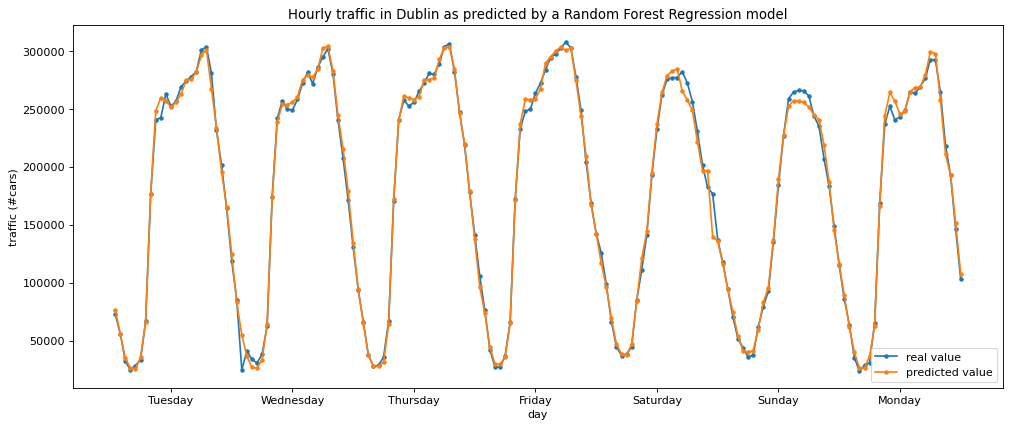

In [15]:
# 12) let's look at a specific week in the test set and compare the predicted outcomes to the true outcomes
subset = 168 # hours in a week
week = 20 # week of the testset, with the first week being 0
predindices = flatinc[subset*week:subset*week+subset] # indices of the selected week in the test set

x = X.index[predindices]
y1 = y_test[predindices]
y2 = y_pred_r[subset*week:subset*week+subset]

# setup x-ticks
xloc = np.arange(predindices[11],predindices[subset-12],24)
xlab = sourcedata.loc[xloc]['day']

figure(figsize=(15, 6), dpi=80)

plt.plot(x,y1,marker='.',label = 'real value')
plt.plot(x,y2,marker='.',label = 'predicted value')
plt.xticks(xloc,labels=xlab)
plt.xlabel("day")
plt.ylabel("traffic (#cars)")
plt.title("Hourly traffic in Dublin as predicted by a Random Forest Regression model")
plt.legend()

Looks like the model is quite accurate! Let's calculate the performance and see which parameters are most important.

In [16]:
# 13) calculate the performance
mae_r = mean_absolute_error(y_test, y_pred_r)
mse_r = mean_squared_error(y_test, y_pred_r)
score = rfModel.score(X_test,y_test,sample_weight=None)

print(f"mean absolute error: {mae_r}, \nmean squared error: {mse_r}, \ncoefficient of determination: {score}")

mean absolute error: 15183.60518452381, 
mean squared error: 775946073.4580319, 
coefficient of determination: 0.9185585048336463


The coefficient of determination (R^2) is a measure to score a Random Forest Regression model. A perfect model gets a value of 1, so this model is doing well. Let's inspect the importance of the feature variables.

Text(0.5, 1.0, 'importance of features')

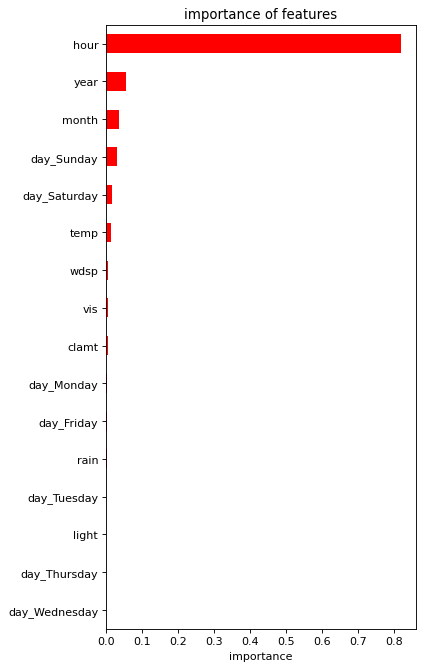

In [17]:
# 14) explain random forest model
importance = rfModel.feature_importances_
columns = X.columns
figure(figsize=(5, 10), dpi=80)
rfGraph = pd.Series(importance, columns)
rfGraph.sort_values().plot.barh(color = "red")
plt.xlabel('importance')
plt.title('importance of features')

Clearly, the hour of the day is by far the most important predictor for the traffic volume. The year, month and whether it is weekend or not also matters. The weather parameters that have been put into the model hardly influence traffic

In [18]:
# 15) save the model
modelname = 'MLmodel.joblib'
dump(rfModel, modelname) 

['MLmodel.joblib']

We have now trained a ML model on historical data. Now let's use the model to predict future traffic. Open the next script '3_run_model.ipynb' and run the script cell by cell.